# Executive Summary

In [ ]:
# Methdology / logic: 
# 1) identify drivers of marketing and asssess weight of importance
# 2) optmize: click thru rate = func(drivers, target audience)
# 3) design experiment to evaluate the effectiveness of new strategy

In [202]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## 1.Data Operations

In [2]:
os.chdir('/Users/yupinghe/Documents/Data-Science-Take-Home-Challenges/Data Science Take Home Challenges/Marketing Email Campaign/email')

In [3]:
# Import data
d0 = pd.read_csv('email_opened_table.csv')
d0['opened']=1
d1 = pd.read_csv('email_table.csv')
d2 = pd.read_csv('link_clicked_table.csv')
d2['clicked'] = 1

In [4]:
# Merge into 1 dataset
d = pd.merge(d1, d0, left_on='email_id', right_on='email_id', how='left')
d = pd.merge(d, d2, left_on='email_id', right_on='email_id', how='left')
d.loc[:,['clicked','opened']] = d.loc[:,['clicked','opened']].fillna(0)

In [5]:
# 50 emails were not opened but with links clicked
d['flagged'] = 0
d.loc[(d['clicked']==1) & (d['opened']==0),'flagged'] = 1

## 2. Data Quality Report

In [12]:
d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 10 columns):
email_id               100000 non-null int64
email_text             100000 non-null object
email_version          100000 non-null object
hour                   100000 non-null int64
weekday                100000 non-null object
user_country           100000 non-null object
user_past_purchases    100000 non-null int64
opened                 100000 non-null float64
clicked                100000 non-null float64
flagged                100000 non-null int64
dtypes: float64(2), int64(4), object(4)
memory usage: 8.4+ MB


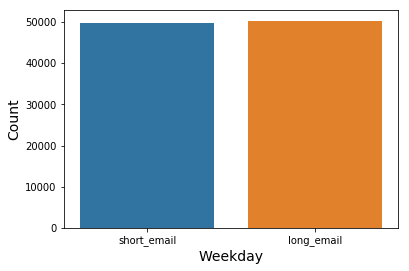

In [40]:
# email_text

sns.countplot(x="email_text", data=d)

plt.xlabel('Weekday', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

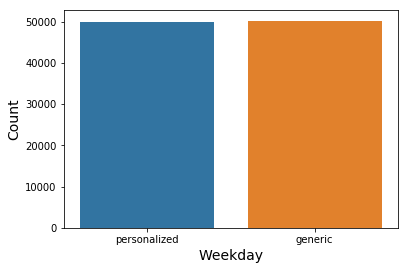

In [39]:
# email_version

sns.countplot(x="email_version", data=d)

plt.xlabel('Weekday', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

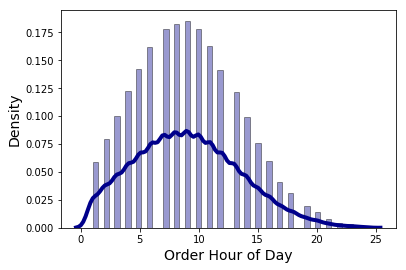

In [38]:
# hour

sns.distplot(d['hour'], 
             hist=True, 
             kde=True,
             #bins=int(180/5), 
             color = 'darkblue', # for histogram bars
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.xlabel('Order Hour of Day', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.show()

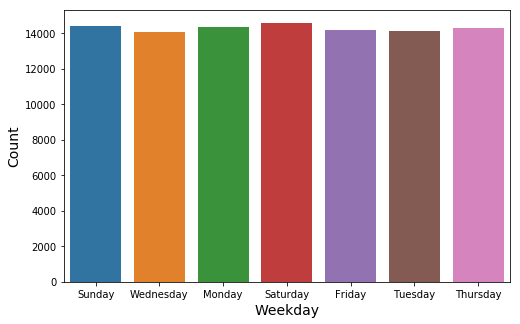

In [32]:
# weekday

plt.figure(figsize=(8,5))

sns.countplot(x="weekday", data=d)

plt.xlabel('Weekday', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

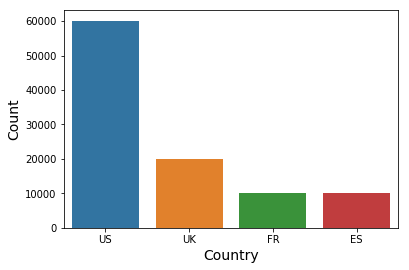

In [37]:
# user_country


sns.countplot(x="user_country", data=d)

plt.xlabel('Country', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

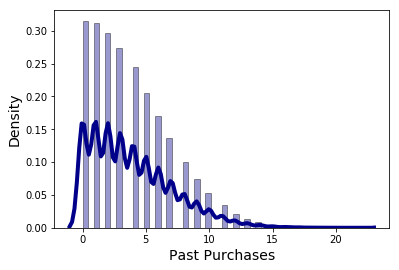

In [27]:
# user_past_purchases

sns.distplot(d['user_past_purchases'], 
             hist=True, 
             kde=True,
             #bins=int(180/5), 
             color = 'darkblue', # for histogram bars
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.xlabel('Past Purchases', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.show()

In [69]:
d['opened'].astype(object).value_counts()

0.0    89655
1.0    10345
Name: opened, dtype: int64

### 2.1 Missing Value Imputation

In [6]:
# 50 emails were not opened but with links clicked
d['flagged'] = 0
d.loc[(d['clicked']==1) & (d['opened']==0),'flagged'] = 1

In [7]:
d_cleaned = d.loc[d['flagged']==0,:]

d_cleaned.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked,flagged
0,85120,short_email,personalized,2,Sunday,US,5,0.0,0.0,0
1,966622,long_email,personalized,12,Sunday,UK,2,1.0,1.0,0
2,777221,long_email,personalized,11,Wednesday,US,2,0.0,0.0,0
3,493711,short_email,generic,6,Monday,UK,1,0.0,0.0,0
4,106887,long_email,generic,14,Monday,US,6,0.0,0.0,0


## 3. Feature Engineering

In [53]:
d_cleaned['email_id'].nunique()


(99950, 10)

In [136]:
# Data Partition

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

train_index = d_cleaned.set_index('email_id').sample(frac=0.7, replace=False, random_state=4).index
test_index = d_cleaned.set_index('email_id').drop(train_index).index

### 3.1 Target Encoding

In [137]:
# Target encoding for categorical variables

# from training set only
d_cleaned2 = d_cleaned.copy()

for column in ['email_text', 'email_version', 'weekday', 'user_country']:
    # get mean by category
    temp = d_cleaned.loc[train_index,:].groupby(column)['opened'].agg({column+'_encoded':'mean'}).reset_index()
    # attach encoded value
    d_cleaned2 = pd.merge(d_cleaned2, temp, left_on=column, right_on=column, how='left')
    
    del temp


/Users/yupinghe/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/yupinghe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


In [147]:
final_variables = ['hour',
                   'user_past_purchases',
                   'email_text_encoded',
                   'email_version_encoded',
                   'weekday_encoded',
                   'user_country_encoded']

print(d_cleaned2.shape)
d_cleaned2.head()

(99950, 14)


,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked,flagged,email_text_encoded,email_version_encoded,weekday_encoded,user_country_encoded
0,85120,short_email,personalized,2,Sunday,US,5,0.0,0.0,0,0.115795,0.127451,0.092381,0.119728
1,966622,long_email,personalized,12,Sunday,UK,2,1.0,1.0,0,0.095733,0.127451,0.092381,0.118819
2,777221,long_email,personalized,11,Wednesday,US,2,0.0,0.0,0,0.095733,0.127451,0.125000,0.119728
3,493711,short_email,generic,6,Monday,UK,1,0.0,0.0,0,0.115795,0.083944,0.118547,0.118819
4,106887,long_email,generic,14,Monday,US,6,0.0,0.0,0,0.095733,0.083944,0.118547,0.119728


## 4. Model Development

### 4.1 Data Pre-processing

In [175]:
# Data partition

X_train = d_cleaned2.set_index('email_id').loc[train_index,final_variables]
X_test = d_cleaned2.set_index('email_id').loc[test_index,final_variables]

y_train = d_cleaned2.set_index('email_id').loc[train_index,['opened']]
y_test = d_cleaned2.set_index('email_id').loc[test_index,['opened']]

In [156]:
# Scaling
pipe = Pipeline([
    #('selector', DataFrameSelector(numeric.columns.tolist())),
    ('scaler', StandardScaler()),
])


In [176]:
X_train = pipe.fit_transform(X_train)
X_test = pipe.fit_transform(X_test)

/Users/yupinghe/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/yupinghe/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/yupinghe/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/yupinghe/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


### 4.2 Baseline Model: Logistic Regression

### 4.3 Random Forest

#### 4.31 Hyperparameter Tuning

In [186]:
rf = RandomForestClassifier(bootstrap=True
                            ,oob_score=True
                            ,random_state=4 # seed
                            ,n_jobs=-1 # using all processors
                            ,criterion='gini')


params = {'max_features': ['auto'] # sqrt(n_features)
          ,"min_samples_leaf" : [5, 10]
          ,"min_samples_split" : [10, 20]
          ,"n_estimators": [100, 200]
         }

gs = GridSearchCV(estimator=rf
                  ,param_grid=params
                  ,scoring='roc_auc'
                  ,cv=3
                 )


In [190]:
grid_result = gs.fit(X_train, np.ravel(y_train))

print('Best parameters: ',grid_result.best_params_)
print(grid_result.best_estimator_)
print('Best AUC: 'grid_result.best_score_)

#print(grid_result.cvresults)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=True, random_state=4, verbose=0, warm_start=False)
0.6465453408200651
{'max_features': 'auto', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 200}


#### 4.32 Model Evaluation

In [199]:
# Fit the finalized model on entire training set

# rf = grid_result.best_estimator_

rf_final = RandomForestClassifier(criterion='gini', 
                             n_estimators=200,
                             min_samples_split=10,
                             min_samples_leaf=10,
                             max_features='auto',
                             oob_score=True,
                             random_state=4,
                             n_jobs=-1,
                             bootstrap=True)


rf_final.fit(X_train, np.ravel(y_train))
#print("%.4f" % rf_final.oob_score_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=True, random_state=4, verbose=0, warm_start=False)

In [204]:
y_pred = rf_final.predict_proba(X_test)[:,1]
print('AUC: ', roc_auc_score(y_test, y_pred))

AUC:  0.638182069682059


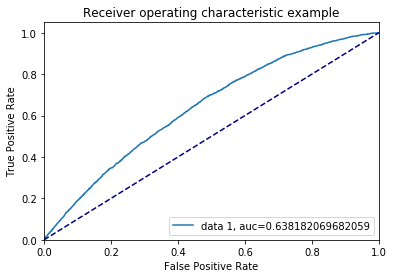

In [207]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr, tpr, label="data 1, auc="+str(auc))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [216]:
# feature importance
pd.concat((pd.DataFrame(d_cleaned2.loc[:, final_variables].columns, columns = ['Variable']), 
          pd.DataFrame(rf_final.feature_importances_, columns = ['Importance'])), 
          axis = 1)\
    .sort_values(by='Importance', ascending = False)

,Variable,Importance
0,hour,0.330150
1,user_past_purchases,0.320560
4,weekday_encoded,0.147293
5,user_country_encoded,0.117049
3,email_version_encoded,0.053418
2,email_text_encoded,0.031530


# Results